Importation des library

In [1]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [2]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "5m"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2025-11-01', 
    interval=time,
    tz_convert='Europe/Paris',
)

0it [00:00, ?it/s]

Mise en forme des données

In [3]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-13 16:45:00+01:00,3107.06,3113.32,3113.33,3104.96,713.4836
2025-12-13 16:50:00+01:00,3110.27,3107.05,3110.69,3105.98,417.6822
2025-12-13 16:55:00+01:00,3109.63,3110.27,3111.22,3109.58,263.8412
2025-12-13 17:00:00+01:00,3116.36,3109.63,3116.37,3109.37,715.3998
2025-12-13 17:05:00+01:00,3112.69,3116.37,3116.37,3110.51,310.4870


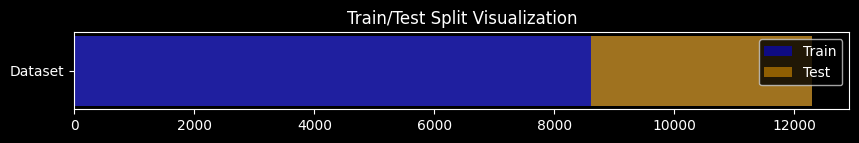

In [4]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [1]:
# Selection du train_set comme données d'entrainement
df = test_data.copy()

NameError: name 'test_data' is not defined

In [ ]:
import vectorbt as vbt
import plotly.graph_objects as go

close = df['Close']

# ================================================
# 1) EMA
# ================================================
ema9  = vbt.MA.run(close, window=9, ewm=True).ma
ema50 = vbt.MA.run(close, window=50, ewm=True).ma

# ================================================
# 2) VWAP
# ================================================
vwap = vbt.VWAP.run(
    high=df['High'],
    low=df['Low'],
    close=close,
    volume=df['Volume']
).vwap

# ================================================
# 3) Signaux
# ================================================
entries = ema9.vbt.crossed_above(ema50)
exits   = ema9.vbt.crossed_below(ema50)

tp_vwap = close >= vwap  # TP logique

# ================================================
# 4) Backtest
# ================================================
pf_vwap = vbt.Portfolio.from_signals(
    close,
    entries,
    exits | tp_vwap,
    init_cash=10_000,
    fees=0.0004,
    slippage=0.0002,
    freq='5m'
)

print("===== VWAP TP =====")
print(pf_vwap.stats())

# ================================================
# 5) Graphique
# ================================================
trades = pf_vwap.trades.records_readable

fig = go.Figure()

# Bougies
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=close,
    name="Prix",
    increasing_line_color='rgba(0,200,0,0.6)',
    decreasing_line_color='rgba(200,0,0,0.6)',
    increasing_fillcolor='rgba(0,200,0,0.3)',
    decreasing_fillcolor='rgba(200,0,0,0.3)'
))

# EMA
fig.add_trace(go.Scatter(x=df.index, y=ema9,  name="EMA 9",  line=dict(color='green')))
fig.add_trace(go.Scatter(x=df.index, y=ema50, name="EMA 50", line=dict(color='orange')))

# VWAP
fig.add_trace(go.Scatter(
    x=df.index,
    y=vwap,
    name="VWAP",
    line=dict(color='purple', width=2)
))

# Entrées / sorties
fig.add_trace(go.Scatter(
    x=trades['Entry Timestamp'],
    y=trades['Avg Entry Price'],
    mode='markers',
    marker=dict(color='lime', size=9),
    name='Buy'
))

fig.add_trace(go.Scatter(
    x=trades['Exit Timestamp'],
    y=trades['Avg Exit Price'],
    mode='markers',
    marker=dict(color='red', size=9),
    name='Sell'
))

fig.update_layout(
    title="EMA Cross + TP VWAP",
    template="plotly_dark",
    height=800,
    xaxis_rangeslider_visible=False
)

fig.show()


Start                         2025-11-30 21:35:00+01:00
End                           2025-12-13 17:05:00+01:00
Period                                 12 days 19:35:00
Start Value                                     10000.0
End Value                                   9913.415569
Total Return [%]                              -0.865844
Benchmark Return [%]                           2.931168
Max Gross Exposure [%]                            100.0
Total Fees Paid                               481.63203
Max Drawdown [%]                               9.544241
Max Drawdown Duration                   9 days 14:55:00
Total Trades                                         60
Total Closed Trades                                  59
Total Open Trades                                     1
Open Trade PnL                               -17.644214
Win Rate [%]                                  16.949153
Best Trade [%]                                  6.21712
Worst Trade [%]                               -1